In [2]:
"""
Model Parameters :  
    GRAPH :
        directed
        node :
            node_id
            label
            probability
        edge :
            source
            target

    n -> population size
    k -> seed set size
    flight_length -> flight lengths of crows
    epoch -> max number of iterations
    awareness_probability-> awareness probability 
    alpha -> constant to calculate node_contribution_index. used for optimisation using random walk
    beta ->  constant to select candidates for random walk

    SAME AS DPSO ONLY LOCAL SEARCH TECHNIQUE IS CHANGED
"""


'\nModel Parameters :  \n    GRAPH :\n        directed\n        node :\n            node_id\n            label\n            probability\n        edge :\n            source\n            target\n\n    n -> population size\n    k -> seed set size\n    flight_length -> flight lengths of crows\n    epoch -> max number of iterations\n    awareness_probability-> awareness probability \n    alpha -> constant to calculate node_contribution_index. used for optimisation using random walk\n    beta ->  constant to select candidates for random walk\n\n    SAME AS DPSO ONLY LOCAL SEARCH TECHNIQUE IS CHANGED\n'

In [3]:
import networkx as nx
import random 
import itertools
import numpy as np
import pandas as pd
import matplotlib as plt

[(1, {'label': 1, 'probability': 0.89}), (2, {'label': 2, 'probability': 0.58}), (3, {'label': 3, 'probability': 0.32}), (4, {'label': 4, 'probability': 0.68}), (5, {'label': 5, 'probability': 0.83}), (6, {'label': 6, 'probability': 0.06}), (7, {'label': 7, 'probability': 0.15}), (8, {'label': 8, 'probability': 0.31}), (9, {'label': 9, 'probability': 0.59}), (10, {'label': 10, 'probability': 0.35}), (11, {'label': 11, 'probability': 0.23}), (12, {'label': 12, 'probability': 0.76}), (13, {'label': 13, 'probability': 0.78}), (14, {'label': 14, 'probability': 0.75}), (15, {'label': 15, 'probability': 0.4}), (16, {'label': 16, 'probability': 0.9}), (17, {'label': 17, 'probability': 0.97}), (18, {'label': 18, 'probability': 0.34}), (19, {'label': 19, 'probability': 0.99}), (20, {'label': 20, 'probability': 0.58}), (21, {'label': 21, 'probability': 0.71}), (22, {'label': 22, 'probability': 0.56}), (23, {'label': 23, 'probability': 0.91}), (24, {'label': 24, 'probability': 0.23}), (25, {'labe

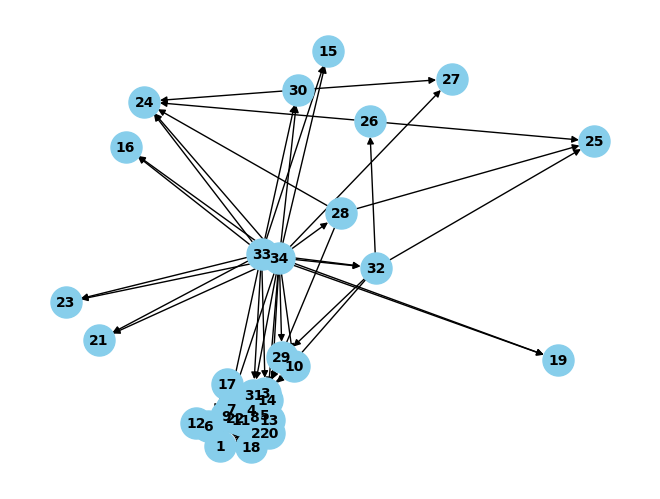

In [4]:
#build graph from data
G = nx.read_gml("../tests/test1.gml", label = 'id')

#visualizing the graph
print(G.nodes(data=True))
print(G.edges(data=True))

# Define node positions (optional)
pos = nx.spring_layout(G)
# Get node labels
node_labels = {node: data['label'] for node, data in G.nodes(data=True)}
# Draw the graph
nx.draw(G, pos, with_labels=True, labels=node_labels, node_size=500, node_color='skyblue', font_size=10, font_color='black', font_weight='bold')


In [21]:
print(G.out_degree())

[(1, 0), (2, 1), (3, 2), (4, 3), (5, 1), (6, 1), (7, 3), (8, 4), (9, 2), (10, 1), (11, 3), (12, 1), (13, 2), (14, 4), (15, 0), (16, 0), (17, 2), (18, 2), (19, 0), (20, 2), (21, 0), (22, 2), (23, 0), (24, 0), (25, 0), (26, 2), (27, 0), (28, 3), (29, 1), (30, 2), (31, 2), (32, 4), (33, 11), (34, 17)]


In [6]:
#replace for diversity in crow nodes
def replace(j, position ,left):
    if(len(left) == 0):
        return position[j]
    index = random.randint(0,len(left) - 1)
    position[j], left[index] = left[index], position[j]
    return position[j]


# returns a list of crow positions 
def initialize_population(G : nx.classes.digraph.DiGraph, n : int, k: int) :
    nodes_degree = np.array(G.out_degree(), dtype=[('node_id', int), ('out_degree', int)])
    nodes_degree = np.array([x[0] for x in nodes_degree[np.argsort(nodes_degree['out_degree'])]])

    population = np.empty((n, k))
    for i in range(n) :
        position, left = nodes_degree[:k], nodes_degree[k:]
        for j in range(k):
            if(random.random() > 0.5):                                                          # REPLACEMENT PARAMETER = 0.5 
                position[j] = replace(j,position,left)
        population[i] = position
    return population


In [7]:
initialize_population(G, 3, 5)

array([[ 4., 29., 15., 23., 24.],
       [11.,  7., 15., 23., 30.],
       [31.,  7., 15., 25., 30.]])

In [8]:
def local_influence_estimate(G : nx.classes.digraph.DiGraph, seed : np.ndarray ) :
    k = len(seed)

    one_neighbours = np.array([])
    for node_id in seed :
        one_neighbours =  np.union1d(one_neighbours, np.array(list(G.neighbors(node_id))))
    one_neighbours = np.setdiff1d(one_neighbours, seed)

    two_neighbours = np.array([])
    for node_id1 in one_neighbours :
        two_neighbours =  np.union1d(two_neighbours, np.array(list(G.neighbors(node_id1))))
    two_neighbours = np.setdiff1d(two_neighbours, seed)

    one_hop_area = one_neighbours.size
    if one_hop_area == 0:
        return k
    two_hop_area = two_neighbours.size

    sigma_0 = k
    sigma_1 = 0
    for node_id1 in one_neighbours:
        val = 1
        for node_id in seed:
            if(G.has_edge(node_id1,node_id)) :
                p = G.nodes[node_id]['probability']
                val = val * ( 1 - p)
        sigma_1 += (1 - val)

    factor = 0

    
    for node_id2 in two_neighbours:
        p = G.nodes[node_id2]['probability']
        d = 0
        for node_id1 in one_neighbours:
            if(G.has_edge(node_id2, node_id1)):
                d += 1
        factor += p*d 
       
    factor /= one_hop_area
    factor += 1

    LIE = sigma_0 + factor * sigma_1
    return LIE

In [9]:
local_influence_estimate(G, np.array([1,20,30,5,16]))

5.89

In [10]:
def get_updated_seed(seed, r, flight_length, memory):
    k = len(seed)

    intersection = set(seed).intersection(set(memory))
    seed_intersection_memory = [0 if node_id in intersection else 1 for node_id in seed]
    H_arg = [r * flight_length * sim for sim in seed_intersection_memory]
    H_val = [0 if H_arg_j < 1 else 1 for H_arg_j in H_arg]

    left = list(set(G.nodes()) - set(seed))
    seed = [seed[j] if H_val[j] == 0 else replace(j,seed,left) for j in range(k)]
    return seed;    

In [11]:
#TEST
get_updated_seed([1,20,30,5,16], 3, 2, [29,15,32,2,20] )

[22, 20, 10, 1, 4]

In [12]:
def get_best_seed(G : nx.classes.digraph.DiGraph, vec_position : np.ndarray) :
    lie_values = np.array([local_influence_estimate(G,position) for position in vec_position])
    return vec_position[np.argmax(lie_values)]

In [13]:
get_best_seed(G, [[22,13,16], [1,20,13], [19,34,28]])

[1, 20, 13]

In [29]:
def enhanced_local_search(G : nx.classes.digraph.DiGraph, best_seed : list) :
    k = len(best_seed)
    sorted_node_degree =  sorted([(G.out_degree(x),x) for x in best_seed])    
    new_best_seed = [x[1] for x in sorted_node_degree]
    for j in range(k) :
        neighbours = list(set(G.neighbors(new_best_seed[j])) - set(best_seed))
        for idx in range (len(neighbours)):
            new_best_seed[j] = replace(j, new_best_seed ,neighbours)
            if(local_influence_estimate(G, new_best_seed) > local_influence_estimate(G, best_seed)) :
                best_seed = new_best_seed
        new_best_seed = best_seed
    return np.array(best_seed)

In [30]:
enhanced_local_search(G, [28,30,33])

array([24, 25, 19])

In [31]:
def update_velocity(omega : float, velocity : np.ndarray, c1 : float, r1 : float, personal_best : np.ndarray, position : np.ndarray, c2 : float, r2 : float, global_best : np.ndarray) :
    position_intersect_pbest = np.intersect1d(position, personal_best)
    velocity_pbest = np.array([0 if np.isin(node_id,position_intersect_pbest) else 1 for node_id in position])

    position_intersect_gbest = np.intersect1d(position, global_best)
    velocity_gbest = np.array([0 if np.isin(node_id,position_intersect_gbest) else 1 for node_id in position])

    H_arg = omega*velocity + c1 * r1 * velocity_pbest + c2 * r2 * velocity_gbest
    H_val = np.where(H_arg > 2, 1, 0)
    return H_val

In [32]:
def update_position(position, velocity) :
    k = len(position)
    left = np.setdiff1d(np.array(G.nodes()) , position)
    new_position = [position[j] if velocity[j] == 0 else replace(j,position,left) for j in range(k)]
    return np.array(new_position);    

In [33]:

def ELDPSO(G : nx.classes.digraph.DiGraph, n : int, k : int, epoch : int, omega: float , c1 : float, c2 : float):
    """
    Implementation of CROW algorithm for influence maximization in social networks
    
    Args:
    - G: NetworkX directed graph object representing the social network
    - n: size of particle swarm
    - k: size of seed set
    - epoch: maximum number of iterations
    - omega = inertia weight
    - c1, c2 = learning factors

    Returns:
    - nodes: list of k nodes with the highest influence scores
    """

    # Initialize variables
    vec_position = np.array(initialize_population(G,n,k))           # == X       [n*k]
    vec_personal_best = np.array(initialize_population(G,n,k))      # == Pbest   [n*k]
    vec_velocity = np.zeros((n,k))                                  # == V       [n]
    global_best = get_best_seed(G, vec_position)                    # == Gbest   [k]
    r1, r2 = 0.1, 0.1

    for _ in range(epoch) :
        for i in range(n) :
            vec_velocity[i] = update_velocity(omega=omega, position=vec_position[i], velocity=vec_velocity[i], personal_best=vec_personal_best[i], global_best=global_best, c1=c1, c2=c2,r1=r1,r2=r2)
            vec_position[i] = update_position(position=vec_position[i],velocity=vec_velocity[i]) 
            if(local_influence_estimate(G, vec_position[i]) > local_influence_estimate(G, vec_personal_best[i])) :
                vec_personal_best[i] = vec_position[i]

        global_best = get_best_seed(G, vec_position)
        new_global_best = enhanced_local_search(G, global_best)
        if(local_influence_estimate(G, new_global_best) > local_influence_estimate(G, global_best)) :
            global_best = new_global_best
    return global_best, local_influence_estimate(G, global_best)


In [34]:
n = 10
k = 5
epoch = 1000
omega = 1   
c1 = 1
c2 = 1

ELDPSO(
    G=G, 
    n=n, 
    k=k, 
    epoch=epoch, 
    omega=omega,
    c1=c1,
    c2=c2
    )


(array([14., 25., 12.,  1., 23.]), 7.9548000000000005)